# Initial Setup

In [ ]:
# # install fastai for the hook and annoy for approximate nearest neighbors 
!pip install fastai
!pip install annoy
!pip install gdown

     |████████████████████████████████| 655kB 4.6MB/s 
  Created wheel for annoy: filename=annoy-1.17.0-cp36-cp36m-linux_x86_64.whl size=390354 sha256=7b736015022702bf7547430cbbb0f241385ccb34c60220da47f8a462dd8dd83b
  Stored in directory: /root/.cache/pip/wheels/3a/c5/59/cce7e67b52c8e987389e53f917b6bb2a9d904a03246fadcb1e
Successfully built annoy


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gdown
from fastai.vision import *
from fastai.metrics import accuracy, top_k_accuracy
from annoy import AnnoyIndex
import zipfile
import time
from google.colab import drive
%matplotlib inline


In [ ]:
train_on_gpu = torch.cuda.is_available()
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ... To use GPU, go under edit > notebook settings')
else:
    print('CUDA is available!  Training on GPU ...')
    print(gpu_info)

CUDA is available!  Training on GPU ...
Sat Oct 31 05:15:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    30W / 250W |     10MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                

## Get DeepFashion Data

DeepFashion data set: http://mmlab.ie.cuhk.edu.hk/projects/DeepFashion.html

We are using v1 of the data, with 24K+ images. 

In [ ]:
# get the meta data
url = 'https://drive.google.com/uc?id=1d1nWNVHdIAvzuGyaSrajuPIffQTjbnsp'
output = 'list_category_cloth.txt'
gdown.download(url, output, quiet=False)

url = 'https://drive.google.com/uc?id=1quO7Fck8MsKum4lzeyMSbbSbL6yGAIDJ'
output = 'list_category_img.txt'
gdown.download(url, output, quiet=False)

url = 'https://drive.google.com/uc?id=1_rg5_UZ-ZXkcg0yM_-PlN9yLtYT13sSx'
output = 'list_eval_partition.txt'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1d1nWNVHdIAvzuGyaSrajuPIffQTjbnsp
To: /content/list_category_cloth.txt
100%|██████████| 882/882 [00:00<00:00, 1.13MB/s]
Downloading...
From: https://drive.google.com/uc?id=1quO7Fck8MsKum4lzeyMSbbSbL6yGAIDJ
To: /content/list_category_img.txt
21.4MB [00:00, 74.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_rg5_UZ-ZXkcg0yM_-PlN9yLtYT13sSx
To: /content/list_eval_partition.txt
22.2MB [00:00, 66.6MB/s]


'list_eval_partition.txt'

In [ ]:
# get the images
root_path = './'
url = 'https://drive.google.com/uc?id=1j5fCPgh0gnY6v7ChkWlgnnHH6unxuAbb'
output = 'img.zip'
gdown.download(url, output, quiet=False)
with zipfile.ZipFile("img.zip","r") as zip_ref:
    zip_ref.extractall(root_path)

Downloading...
From: https://drive.google.com/uc?id=1j5fCPgh0gnY6v7ChkWlgnnHH6unxuAbb
To: /content/img.zip
2.68GB [00:39, 67.7MB/s]


In [ ]:
category_list = []
image_path_list = []
data_type_list = []
# category names
with open('list_category_cloth.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            category_list.append(line.split(' ')[0])

# category map
with open('list_category_img.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            image_path_list.append([word.strip() for word in line.split(' ') if len(word) > 0])


# train, valid, test
with open('list_eval_partition.txt', 'r') as f:
    for i, line in enumerate(f.readlines()):
        if i > 1:
            data_type_list.append([word.strip() for word in line.split(' ') if len(word) > 0])

In [ ]:
data_df = pd.DataFrame(image_path_list, columns=['image_path', 'category_number'])
data_df['category_number'] = data_df['category_number'].astype(int)
data_df = data_df.merge(pd.DataFrame(data_type_list, columns=['image_path', 'dataset_type']), on='image_path')
data_df['category'] = data_df['category_number'].apply(lambda x: category_list[int(x) - 1])
data_df = data_df.drop('category_number', axis=1)
data_df.head()

image_path dataset_type category
0  img/Sheer_Pleated-Front_Blouse/img_00000001.jpg        train   Blouse
1  img/Sheer_Pleated-Front_Blouse/img_00000002.jpg        train   Blouse
2  img/Sheer_Pleated-Front_Blouse/img_00000003.jpg          val   Blouse
3  img/Sheer_Pleated-Front_Blouse/img_00000004.jpg        train   Blouse
4  img/Sheer_Pleated-Front_Blouse/img_00000005.jpg         test   Blouse

In [ ]:
len(data_df)

289222

In [ ]:
data_df[['image_path','dataset_type']].groupby('dataset_type').count()

image_path
dataset_type            
test               40000
train             209222
val                40000

In [ ]:
len(data_df.category.unique())

46

In [ ]:
data_df[['image_path','category']].groupby('category').count()

image_path
category               
Anorak              160
Blazer             7495
Blouse            24557
Bomber              309
Button-Down         330
Caftan               54
Capris               77
Cardigan          13311
Chinos              527
Coat               2120
Coverup              17
Culottes            486
Cutoffs            1669
Dress             72158
Flannel             324
Gauchos              49
Halter               17
Henley              716
Hoodie             4048
Jacket            10467
Jeans              7076
Jeggings            594
Jersey              748
Jodhpurs             45
Joggers            4416
Jumpsuit           6153
Kaftan              126
Kimono             2294
Leggings           5013
Onesie               70
Parka               676
Peacoat              97
Poncho              791
Robe                150
Romper             7408
Sarong               32
Shorts            19666
Skirt             14773
Sweater           13123
Sweatpants         3048
Sweatshorts        1106
Tank              15429
Tee               36887
Top               10078
Trunks              386
Turtleneck          146

# Convert images to embeddings

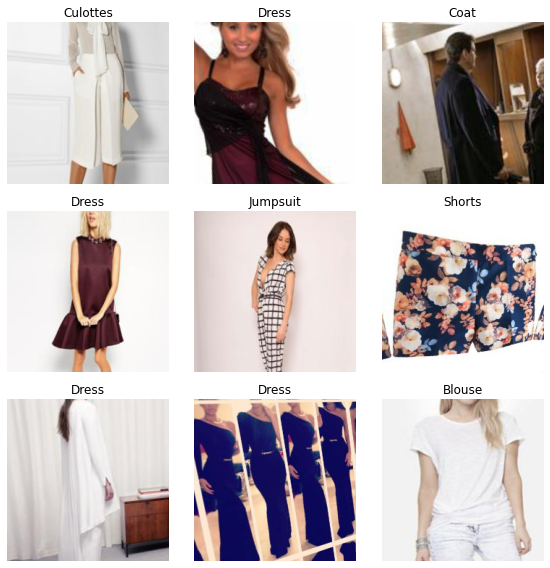

In [ ]:
train_image_list = ImageList.from_df(df=data_df, path=root_path, cols='image_path').split_by_idxs(
    (data_df[data_df['dataset_type']=='train'].index),
    (data_df[data_df['dataset_type']=='val'].index)).label_from_df(cols='category')
test_image_list = ImageList.from_df(df=data_df[data_df['dataset_type'] == 'test'], path=root_path, cols='image_path')

data = train_image_list.transform(get_transforms(), size=224).databunch(bs=128).normalize(imagenet_stats)
data.add_test(test_image_list)
data.show_batch(rows=3, figsize=(8,8))

# Conduct Transfer Learning from ResNet

## Resnet18/50

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-03
Min loss divided by 10: 2.09E-02


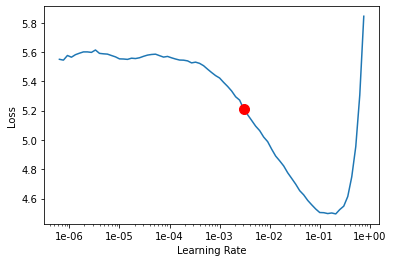

In [ ]:
# see models available: https://docs.fast.ai/vision.models.html
# many options for Resnet, the numbers are the number of layers. 
# More layers are generally more accurate but take longer to train: resnet18, resnet34, resnet50, resnet101, resnet152
# get top 1 and top 5 accuracy
def train_model(data, pretrained_model, model_metrics):
    learner = cnn_learner(data, pretrained_model, metrics=model_metrics)
    learner.model = torch.nn.DataParallel(learner.model)
    learner.lr_find()
    learner.recorder.plot(suggestion=True)
    return learner

pretrained_model = models.resnet18 # simple model that can be trained on free tier
# pretrained_model = models.resnet50 # need pro tier, model I used

model_metrics = [accuracy, partial(top_k_accuracy, k=1), partial(top_k_accuracy, k=5)]
learner = train_model(data, pretrained_model, model_metrics)

In [ ]:
learner.fit_one_cycle(2, max_lr=1e-02)

## Evaluate Model 

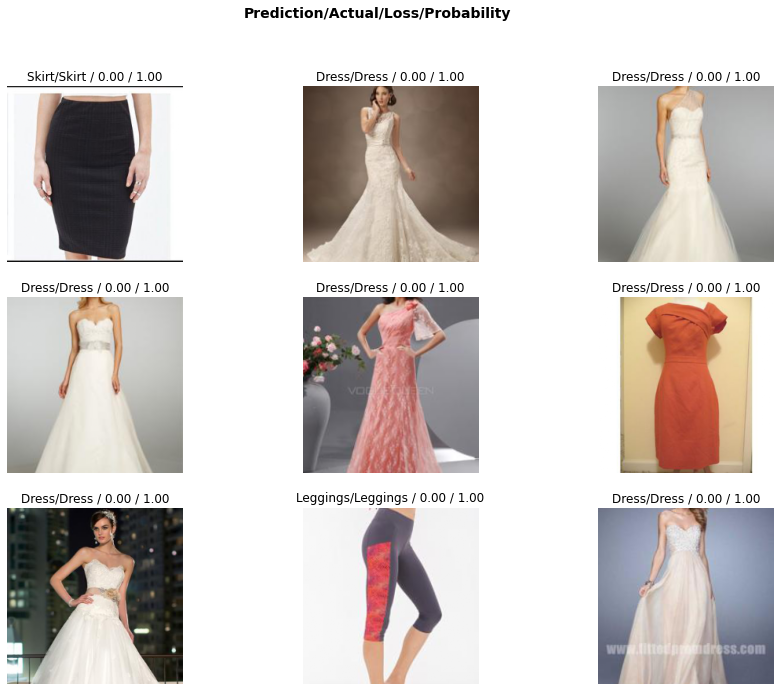

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_top_losses(9, largest=False, figsize=(15,11), heatmap_thresh=5)

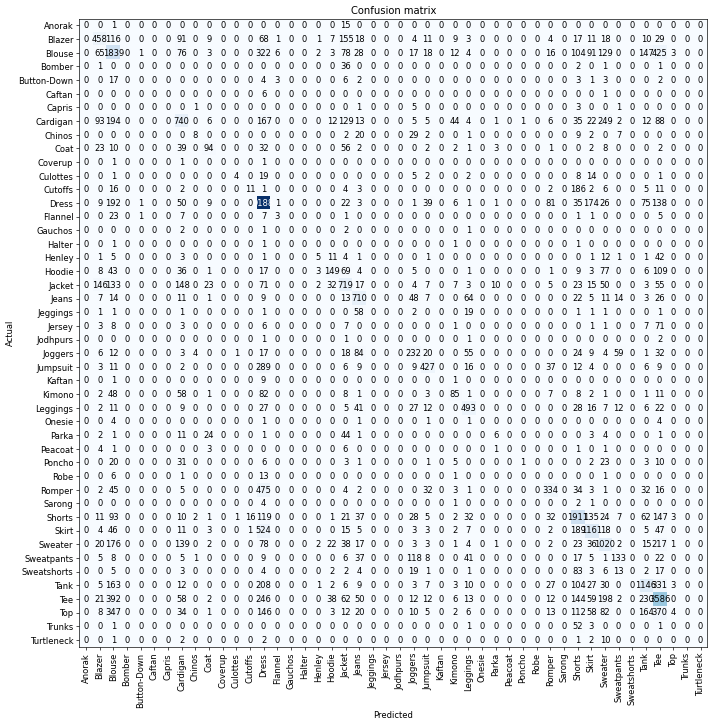

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
# saving the model (temporary, will lose model once environment resets)
learner.save('resnet-fashion')

In [ ]:
# saving the model (permanent), need to enter authorization code
drive.mount('/content/gdrive')
learner.save('/content/gdrive/My Drive/resnet18-fashion')
# learner.save('/content/gdrive/My Drive/resnet50-fashion')

Mounted at /content/gdrive


In [ ]:
# view model details
learner.model.module

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

# Use Fastai hooks to retrieve image embeddings

In [ ]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()

In [ ]:
# load the trained model
def load_learner(data, pretrained_model, model_metrics, model_path):
    learner = cnn_learner(data, pretrained_model, metrics=model_metrics)
    learner.model = torch.nn.DataParallel(learner.model)
    learner = learner.load(model_path)
    return learner

model_metrics = [accuracy, partial(top_k_accuracy, k=1), partial(top_k_accuracy, k=5)]
# if gdrive not mounted:
drive.mount('/content/gdrive') 

pretrained_model = models.resnet18 # simple model that can be trained on free tier
model_path = "/content/gdrive/My Drive/resnet18-fashion"

# pretrained_model = models.resnet50 # need pro tier
# model_path = "/content/gdrive/My Drive/resnet50-fashion"

learner = load_learner(data, pretrained_model, model_metrics, model_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# takes time to populate the embeddings for each image
# Get 2nd last layer of the model that stores the embedding for the image representations
# the last linear layer is the output layer.
saved_features = SaveFeatures(learner.model.module[1][4])
_= learner.get_preds(data.train_ds)
_= learner.get_preds(DatasetType.Valid)

In [ ]:
# prepare the data for generating recommendations (exlcude test data)
# get the embeddings from trained model
img_path = [str(x) for x in (list(data.train_ds.items) +list(data.valid_ds.items))]
label = [data.classes[x] for x in (list(data.train_ds.y.items) +list(data.valid_ds.y.items))]
label_id = [x for x in (list(data.train_ds.y.items) +list(data.valid_ds.y.items))]
data_df_ouput = pd.DataFrame({'img_path': img_path, 'label': label, 'label_id': label_id})
data_df_ouput['embeddings'] = np.array(saved_features.features).tolist()
data_df_ouput

img_path  ...                                         embeddings
0       ./img/Sheer_Pleated-Front_Blouse/img_00000001.jpg  ...  [24.661815643310547, 13.793664932250977, -24.9...
1       ./img/Sheer_Pleated-Front_Blouse/img_00000002.jpg  ...  [15.500744819641113, -11.049653053283691, -4.9...
2       ./img/Sheer_Pleated-Front_Blouse/img_00000004.jpg  ...  [-2.5552473068237305, 22.43941879272461, -38.8...
3       ./img/Sheer_Pleated-Front_Blouse/img_00000008.jpg  ...  [25.56812286376953, 6.710273742675781, -37.691...
4       ./img/Sheer_Pleated-Front_Blouse/img_00000009.jpg  ...  [20.91071128845215, 14.071941375732422, -17.53...
...                                                   ...  ...                                                ...
249217  ./img/Paisley_Print_Babydoll_Dress/img_0000003...  ...  [-24.600252151489258, 6.62250280380249, 38.988...
249218  ./img/Paisley_Print_Babydoll_Dress/img_0000004...  ...  [-40.856407165527344, -15.962688446044922, 44....
249219  ./img/Paisley_Print_Babydoll_Dress/img_0000004...  ...  [-20.103914260864258, -13.879873275756836, 48....
249220  ./img/Paisley_Print_Babydoll_Dress/img_0000004...  ...  [-43.748504638671875, 30.867734909057617, 59.4...
249221  ./img/Paisley_Print_Babydoll_Dress/img_0000005...  ...  [-16.966323852539062, 10.216169357299805, 31.2...

[249222 rows x 4 columns]

# Use Approximate Nearest Neighbors to obtain most similar images

In [ ]:
# Using Spotify's Annoy
def get_similar_images_annoy(annoy_tree, img_index, number_of_items=12):
    start = time.time()
    img_id, img_label  = data_df_ouput.iloc[img_index, [0, 1]]
    # +1 since we drop first image
    similar_img_ids = annoy_tree.get_nns_by_item(img_index, number_of_items+1)
    end = time.time()
    print(f'{(end - start) * 1000} ms')
    # ignore first item as it is always target image
    return img_id, img_label, data_df_ouput.iloc[similar_img_ids[1:]] 


# for images similar to centroid 
def get_similar_images_annoy_centroid(annoy_tree, vector_value, number_of_items=12):
    start = time.time()
    # dontt need +1 since we not dropping first
    similar_img_ids = annoy_tree.get_nns_by_vector(vector_value, number_of_items)
    end = time.time()
    print(f'{(end - start) * 1000} ms')
    # dont ignore first item since we using psudeo vector object
    return data_df_ouput.iloc[similar_img_ids] 


def show_similar_images(similar_images_df, fig_size=[10,10], hide_labels=True):
    if hide_labels:
        category_list = []
        for i in range(len(similar_images_df)):
            # replace category with blank so it wont show in display
            category_list.append(CategoryList(similar_images_df['label_id'].values*0,
                                              [''] * len(similar_images_df)).get(i))
    else:
        category_list = [learner.data.train_ds.y.reconstruct(y) for y in similar_images_df['label_id']]
    return learner.data.show_xys([open_image(img_id) for img_id in similar_images_df['img_path']],
                                category_list, figsize=fig_size)

In [ ]:
# more tree = better approximation
ntree = 100
#"angular", "euclidean", "manhattan", "hamming", or "dot"
metric_choice = 'angular'

annoy_tree = AnnoyIndex(len(data_df_ouput['embeddings'][0]), metric=metric_choice)

# # takes a while to build the tree
for i, vector in enumerate(data_df_ouput['embeddings']):
    annoy_tree.add_item(i, vector)
_  = annoy_tree.build(ntree)

## Embeddings Centroid Detection

In [ ]:
def centroid_embedding(outfit_embedding_list):
    number_of_outfits = outfit_embedding_list.shape[0]
    length_of_embedding = outfit_embedding_list.shape[1]
    centroid = []
    for i in range(length_of_embedding):
        centroid.append(np.sum(outfit_embedding_list[:, i])/number_of_outfits)
    return centroid

In [ ]:
def generate_image_mix(list_1, list_2, number_of_items=12, ratio=0.5):
    list_1_num_items = int(number_of_items * ratio)
    list_2_num_items = number_of_items - list_1_num_items
    list_1_temp = np.random.choice(list_1, list_1_num_items, replace=False)
    list_2_temp = np.random.choice(list_2, list_2_num_items, replace=False)
    return np.append(list_1_temp,list_2_temp)

def get_similar_image(outfit_img_ids):
    outfit_embedding_list = []
    for img_index in outfit_img_ids:
        outfit_embedding_list.append(data_df_ouput.iloc[img_index, 3])

    outfit_embedding_list = np.array(outfit_embedding_list)
    outfit_centroid_embedding = centroid_embedding(outfit_embedding_list)
    outfits_selected = data_df_ouput.iloc[outfit_img_ids] 

    similar_images_df = get_similar_images_annoy_centroid(annoy_tree, outfit_centroid_embedding, 30)
    show_similar_images(similar_images_df, fig_size=[15,15])

185349


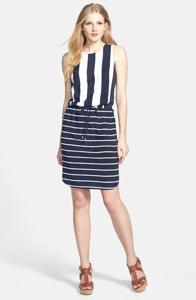

In [ ]:
# image explorer 

# explore a specific type of clothes
# cloth_index = data_df_ouput[data_df_ouput.label=='Coat'].index
# img_index = np.random.choice(cloth_index, 1)[0]

img_index = np.random.randint(len(data_df_ouput),size=1)[0]

print(img_index)
open_image(data_df_ouput.iloc[img_index, 0])

In [ ]:
# Selected Seasons Outfit - Spring, Summer, Autumn, Winter
spring_ids = [60676, 70282, 104154, 235539, 30541, 242857, 73647, 109420, 180461, 169567, 22788, 17442, 166013,
              244809, 13771, 174666, 210204, 246338, 243975, 56543,217299, 84747,164253, 194166]
summer_ids = [237651, 102444, 105986, 23610, 3307, 85789, 50391, 27079, 50438, 183651, 217142,230579,
              118421, 28488, 100845, 211697, 133667, 37422, 195827, 79475, 39237, 192176, 248130, 232170]
autumn_ids = [125328, 28806, 81763, 224471, 66524, 239079, 30221, 114039, 51277, 55470, 221654, 226016, 
              4627, 60861, 175997, 60040, 19313, 99686, 37807, 200329, 82795, 75392, 26517, 60452,
              49650, 120012, 60198, 84413, 34788]
winter_ids = [64161, 227306,165196, 240640, 165222, 240343, 206881, 147516, 248762, 165234,
              206341, 248774, 64297, 148709, 165253, 164704, 223365, 206586, 45383, 219502, 217111, 45191,
              84280, 80393, 85121]



In [ ]:
print(len(spring_ids),len(summer_ids),len(autumn_ids),len(winter_ids))

24 24 29 25


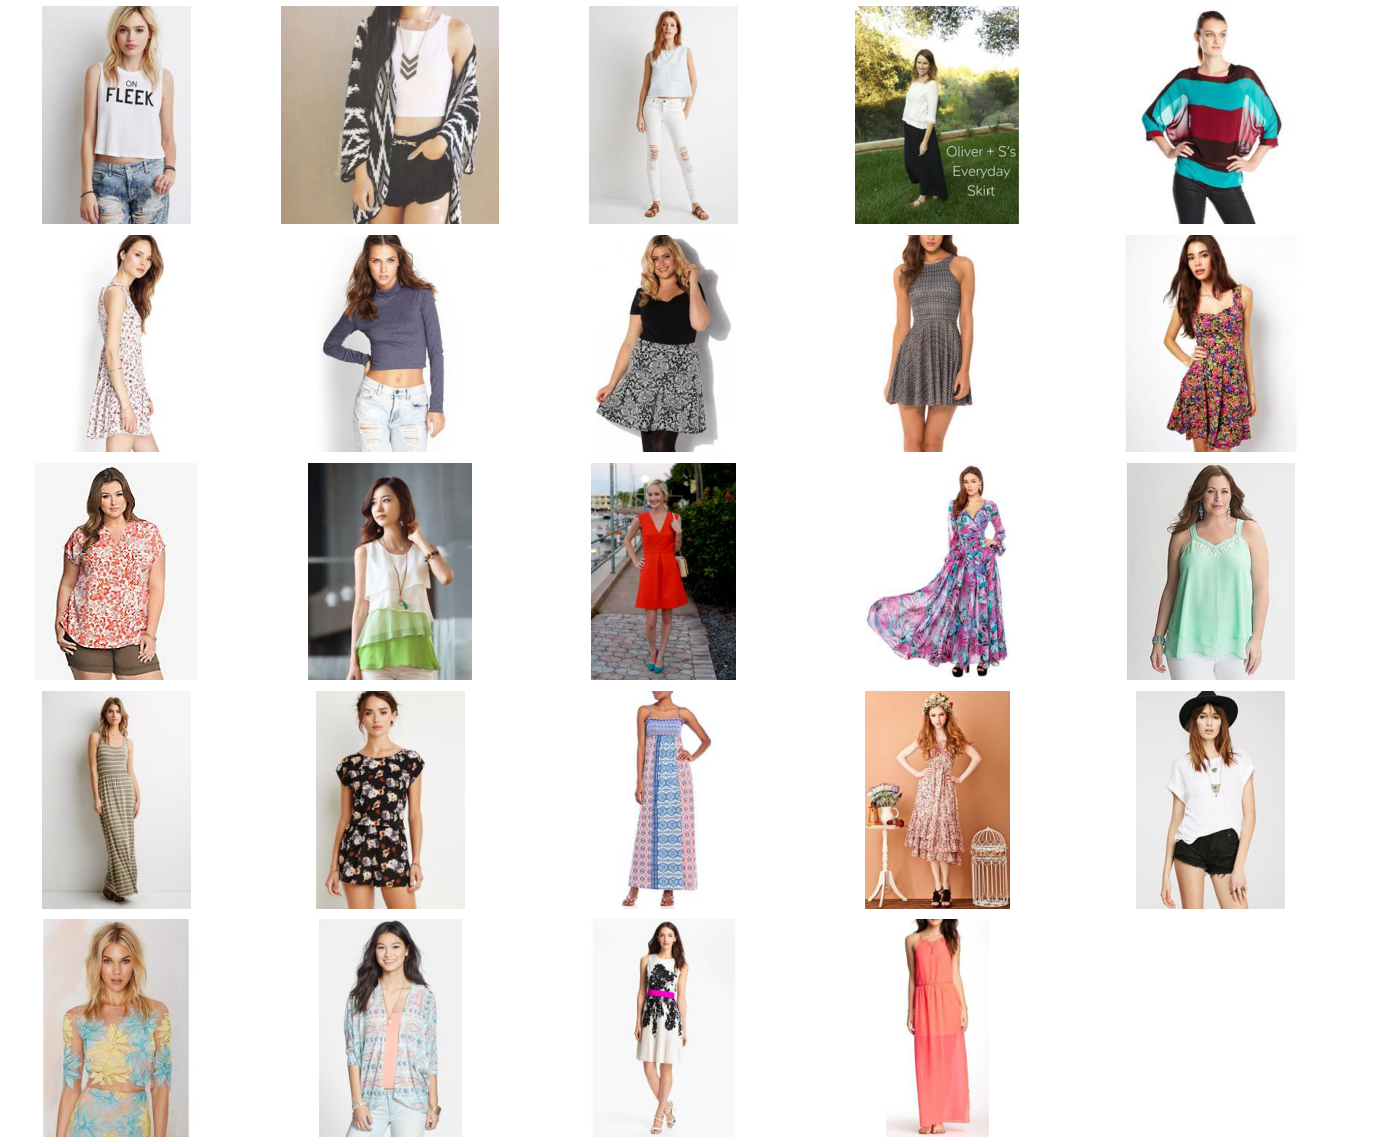

In [ ]:
outfits_selected = data_df_ouput.iloc[spring_ids][0:24] 
show_similar_images(outfits_selected, fig_size=[20,16])

1.8544197082519531 ms


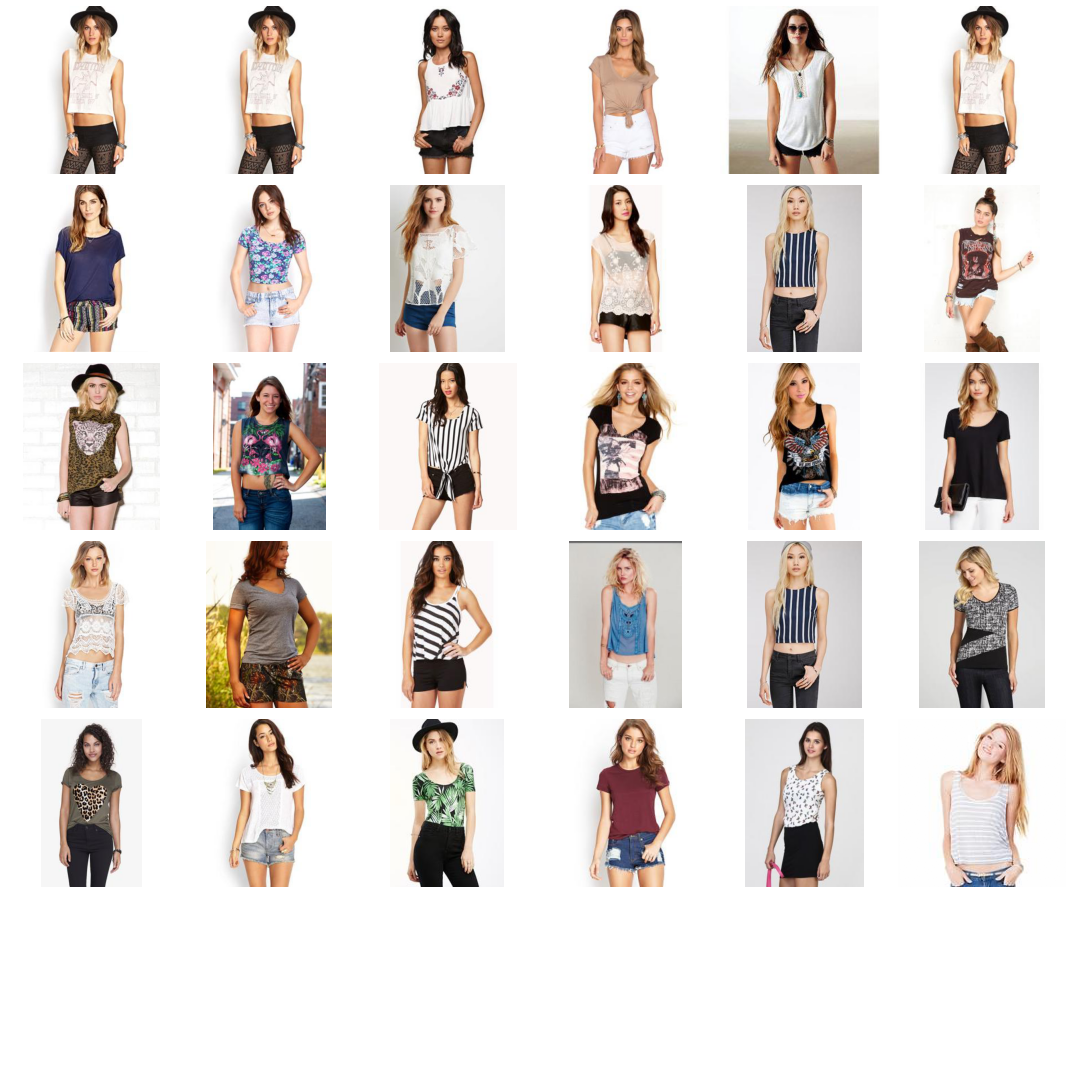

In [ ]:
get_similar_image(generate_image_mix(summer_ids, autumn_ids, number_of_items=24, ratio=1.0))

### Generate Collections

1.6524791717529297 ms


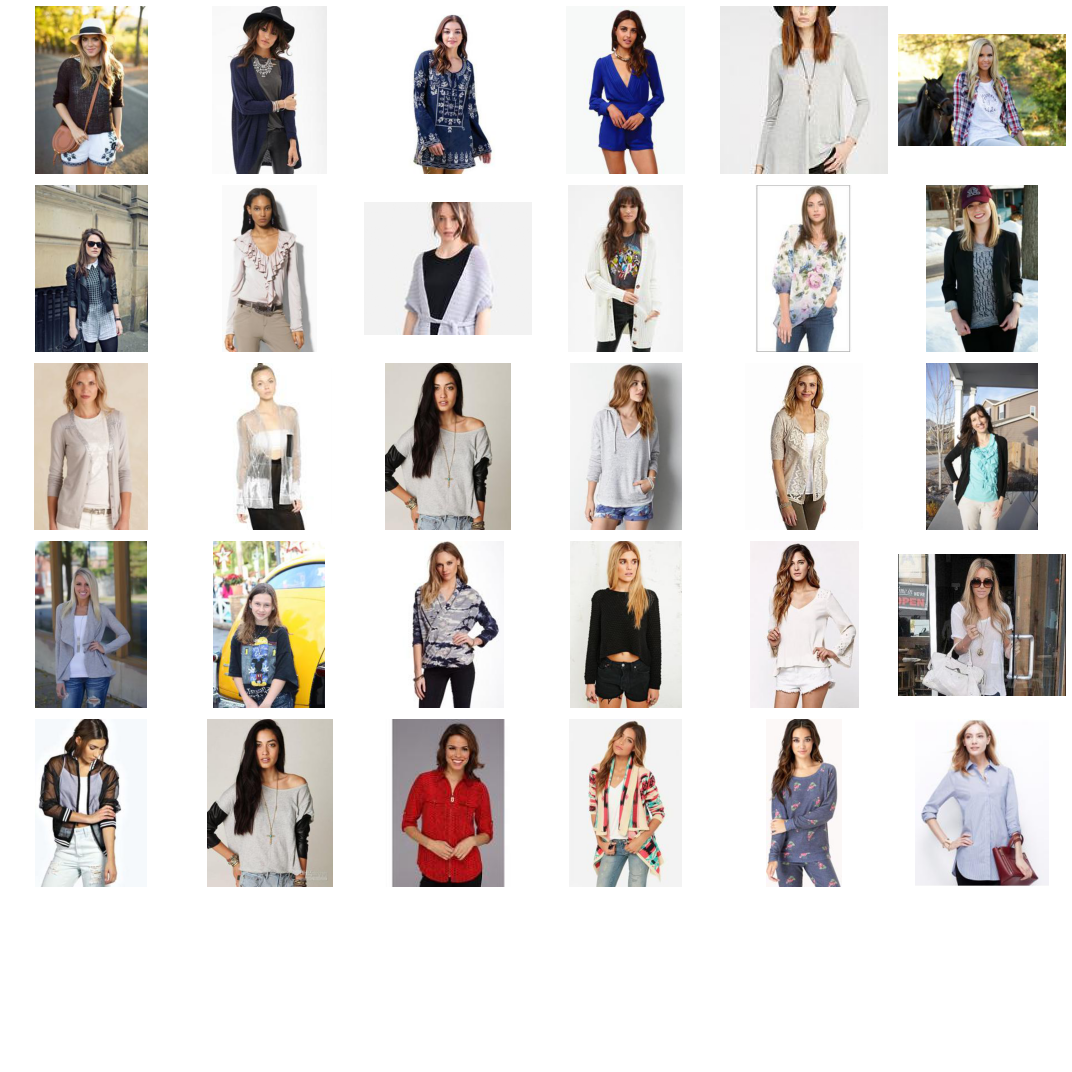

In [ ]:
get_similar_image(generate_image_mix(summer_ids, autumn_ids, number_of_items=24, ratio=0.25))

In [ ]:
get_similar_image(generate_image_mix(winter_ids, spring_ids, number_of_items=24, ratio=1.0))

In [ ]:
get_similar_image(generate_image_mix(winter_ids, spring_ids, number_of_items=24, ratio=0.75))

In [ ]:
get_similar_image(generate_image_mix(winter_ids, spring_ids, number_of_items=24, ratio=0.5))

In [ ]:
get_similar_image(generate_image_mix(winter_ids, spring_ids, number_of_items=24, ratio=0.25))

In [ ]:
get_similar_image(generate_image_mix(winter_ids, spring_ids, number_of_items=24, ratio=0.0))

In [ ]:
get_similar_image(generate_image_mix(summer_ids, autumn_ids, number_of_items=24, ratio=0.0))